# Image classification

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import pylab
import glob
import cv2
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import scale
from sklearn. decomposition import PCA
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from tqdm import tqdm

Using TensorFlow backend.


## 1. Import and clean data

In [2]:
# Set path variable equal to data repository
path = '/home/giovanni/git/gioriz.github.io/data/coil-100/*.png'

# Create a list of strings containing the path and name of each image 
files = glob.glob(path)

def createDF(files):
    
    '''Extract information from string to create a dataframe
       given input string must be ['path']/"obj"/['label']/"__"/['angle'].png
       output is a dataframe with three columns, (path, label, angle)'''
    
    data = []
    for i in files: # for each string
        data.append((i, # path variable
        int(i.split('/')[-1][3:i.split('/')[-1].index('__')]), # label variable (kind of object, our target var)
        int(i.split('/')[-1][i.split('/')[-1].index('__')+2:-4]))) # angle variable (from which angle the object
                                                                   # is captured in the image)
            
    return pd.DataFrame(data,columns=['path','label','angle'])

df = createDF(files)

In [28]:
df.head()

,path,label,angle
0,/home/giovanni/git/gioriz.github.io/data/coil-...,42,225
1,/home/giovanni/git/gioriz.github.io/data/coil-...,66,35
2,/home/giovanni/git/gioriz.github.io/data/coil-...,59,85
3,/home/giovanni/git/gioriz.github.io/data/coil-...,35,100
4,/home/giovanni/git/gioriz.github.io/data/coil-...,31,85


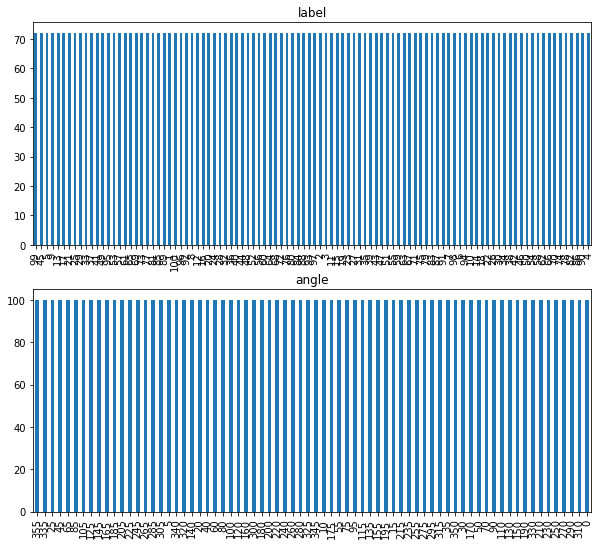

In [132]:
# We check that the target variable are equally distributed.
# It seems this is the case given 100 image each have roughly 72
# images each (each image is at a 5° angle difference 360/72=5).

fig, ax = plt.subplots(2)

m=0
bins = [10,10]
for i in ['label','angle']:
    df[i].value_counts().plot(kind='bar', ax=ax[m], title=i, figsize=(10, 9))
    m+=1

## 2. Modify images 

In [3]:
# We create a train and a test set stratifying by lable in order
# to make sure we have a similar incidence of each object in
# train and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    np.array(df.path), np.array(df.label), test_size=0.3,random_state=13,
    stratify = df.label)

In [4]:
# We have 5040 images as train dataset and 2160 as test dataset
# Each dataset is composed of image paths

print (X_train.shape, X_test.shape)
X_train[1]

(5040,) (2160,)


'/home/giovanni/git/gioriz.github.io/data/coil-100/obj94__230.png'

In [5]:
def rgb2bw(image):
    
    '''Converts an image to black and white by computing a linear
       combination of rgb vector with appropriate weights'''
    luna_object = np.dot(image[...,:3], [0.299, 0.587, 0.114])
    return luna_object.reshape(image.shape[0], image.shape[1])

def file_to_array(file):
    
    '''Converts file to keras image and image into array'''  
    return img_to_array(cv2.imread(file).astype("float")/255.0)

# We extract images into a list of arrays. Original data are colour
# images of 128x128 pixels. So each of the 5040 element of the list is an image 
# encoded as 3 arrays, 2 of which are 128-dimensional coordinate 
# arrays and 1 is a 3 dimensional colour array.

# We then convert them to b&w images of 64x64 pixels. This results 
# in a 12-fold reduction in the weight of each image.

X_train_bw_4096px = np.asarray([cv2.resize(rgb2bw(file_to_array(file)),
    dsize=(64, 64), interpolation=cv2.INTER_AREA) for file in tqdm(X_train)])

X_test_bw_4096px = np.asarray([cv2.resize(rgb2bw(file_to_array(file)),
    dsize=(64, 64), interpolation=cv2.INTER_AREA) for file in tqdm(X_test)])

100%|██████████| 2160/2160 [00:27<00:00, 77.79it/s]


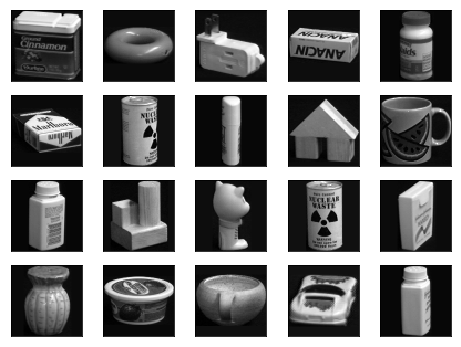

In [7]:
import matplotlib.pyplot as plt
# Let's have a look at these images
fig = plt.figure(figsize=(8, 6))

for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train_bw_4096px[i], cmap='gray')

In [6]:
# We reshape the 3d array to 2d

X_train_bw_4096px_reshaped = X_train_bw_4096px.reshape(
    X_train_bw_4096px.shape[0],
    X_train_bw_4096px.shape[1]*X_train_bw_4096px.shape[2])

X_test_bw_4096px_reshaped = X_test_bw_4096px.reshape(
    X_test_bw_4096px.shape[0],
    X_test_bw_4096px.shape[1]*X_test_bw_4096px.shape[2])

# We center the data and scale to unit variance

X_train_bw_4096px_scaled = scale(X_train_bw_4096px_reshaped)
X_test_bw_4096px_scaled = scale(X_test_bw_4096px_reshaped)

In [36]:
# We try to represent the data on two dimensions using a PCA

pca = PCA(n_components=2, svd_solver='randomized', whiten=True)
X_train_red = pca.fit_transform(X_train_bw_4096px_scaled.data)
X_test_red = pca.fit_transform(X_test_bw_4096px_scaled.data)

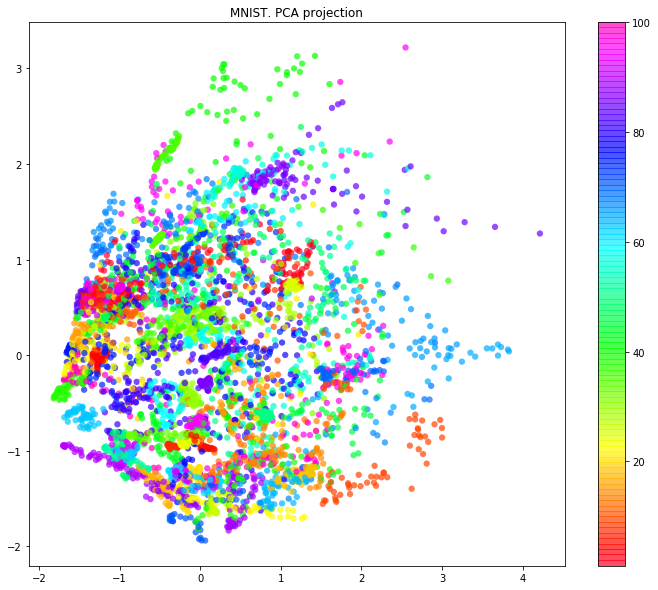

In [57]:
# Of course since we have 100 objects the plot will be messy
# however, we perceive that there are clusters of colours
# indicatinng that the model has limited but significant predictive
# capacity

cm = pylab.get_cmap('gist_rainbow')
for i in range(100):
    color = cm(1.*i/100) 

cgen = (cm(1.*i/100) for i in range(100))

plt.figure(figsize=(12,10))
plt.scatter(X_train_red[:, 0], X_train_red[:, 1], c=y_train, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('gist_rainbow', 100))
plt.colorbar()
plt.title('MNIST. PCA projection');

In [58]:
%%time
clf = LogisticRegression(C=100, multi_class='multinomial', 
                         random_state=17, solver='lbfgs', 
                         max_iter=10000)
clf.fit(X_train_red, y_train)
y_pred = clf.predict(X_test_red)

print("Accuracy: %f" % accuracy_score(y_test, y_pred))

Accuracy: 0.347222
CPU times: user 15.4 s, sys: 459 ms, total: 15.8 s
Wall time: 8.3 s


Note that an accuracy of 35% is actually very good in this case. Since we have 100 possible categories, picking at random would yield successful results in 1% of cases. Therefore our model represents a 35-fold improvement on the benchmark case

CPU times: user 8min 23s, sys: 3.63 s, total: 8min 26s
Wall time: 6min 18s


Text(0.5,1,'MNIST. t-SNE projection')

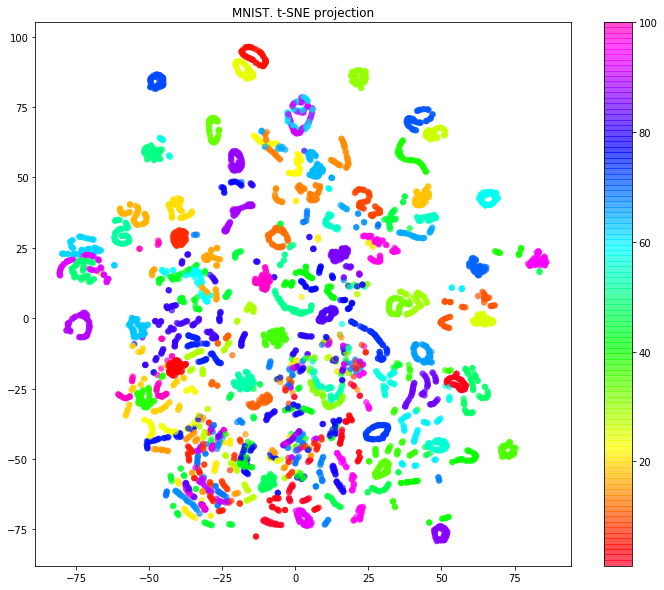

In [60]:
# t-Distributed Stochastic Neighbor Embedding is more effective
# in the case of high order dimensionality, since it minimises 
# the Kullback Leibler divergence, it is not reliant on the 
# linearity assumptions which characterises PCA. Given the numerous
# semi-linear "traces" that appear on the 2-dimensional PCA graph
# (i all likelihood due to the angle rotation of each object) we
# are justified to suspect non-linearity.
# The drawback is that it is not-deterministic as its algorithm has
# numerous local minima

%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X_train_bw_4096px_scaled)

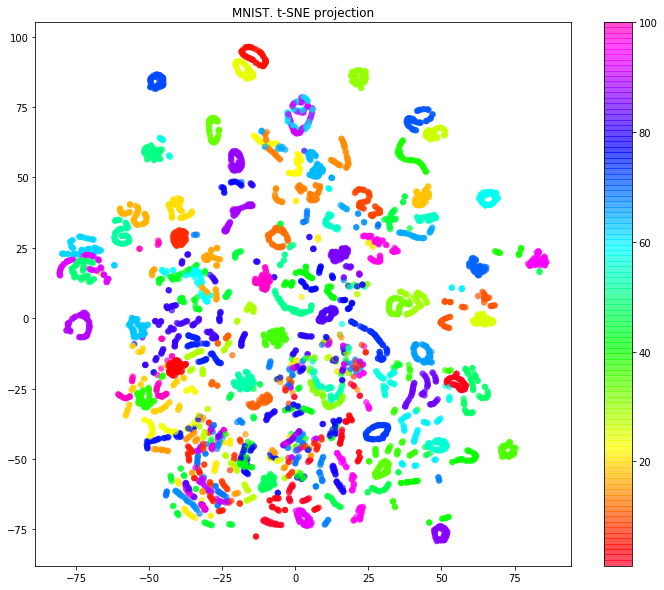

In [61]:
#The image is very satisfying: we see that observations from the 
# same object are grouped together in non-linear groups 
# many of which ring-shaped.

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('gist_rainbow', 100))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

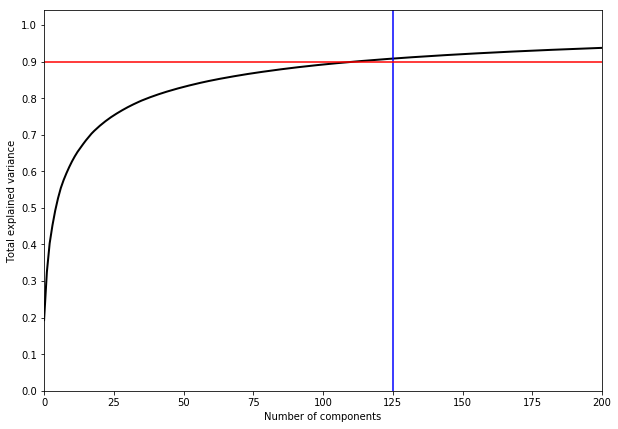

CPU times: user 2min 50s, sys: 16.2 s, total: 3min 7s
Wall time: 1min 54s


In [62]:
%%time
pca = decomposition.PCA(whiten=True).fit(X_train_bw_4096px_scaled)



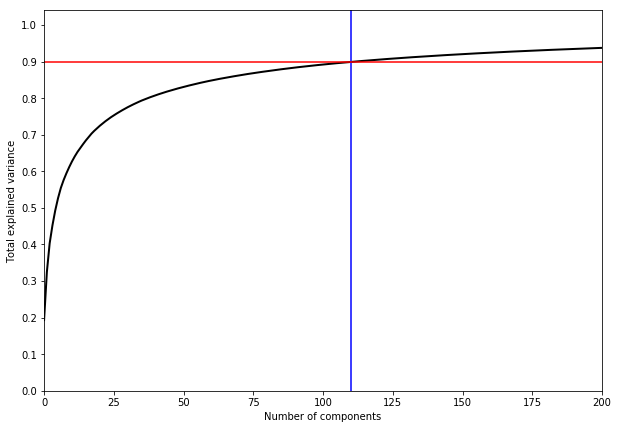

In [66]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 200)
plt.axvline(110, c='b')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.9, c='r')
plt.show();

So with 110 components we should be capturing 90% of the variance. Note that compared to the 4096 original components we have substantially reduced complexity

In [8]:
%%time
pca_optimal = PCA(n_components=110, svd_solver='randomized', whiten=True)
X_red_train_optimal = pca_optimal.fit_transform(X_train_bw_4096px_scaled)
X_red_test_optimal = pca_optimal.fit_transform(X_test_bw_4096px_scaled)

CPU times: user 12.9 s, sys: 1.07 s, total: 14 s
Wall time: 7.58 s


In [9]:
%%time
clf = LogisticRegression(C=100, multi_class='multinomial', 
                         random_state=17, solver='lbfgs', 
                         max_iter=10000)
clf.fit(X_red_train_optimal, y_train)
y_pred = clf.predict(X_red_test_optimal)
print("Accuracy: %f" % accuracy_score(y_test, y_pred))

Accuracy: 0.109722
CPU times: user 29.1 s, sys: 748 ms, total: 29.8 s
Wall time: 15 s


Looks like something is terribly wrong! Accuracy is down to 10%!
Interestingly with only two components, the accuracy was 34%
so with 108 extra components we are actually making a worse estimate.
Something is clearly not right.

In [10]:
clf.score(X_red_train_optimal, y_train)

1.0

AHA! Maybe we are overfitting, and PCA with less components works better only because it reduces dimensioanlity, hence providing a cure for overfitting as side-effect. Let's chose the best regularisation parameter.

In [11]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 100)
logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, 
    verbose=1, n_jobs=3, max_iter=1000)
logit_searcher.fit(X_red_train_optimal, y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 18.5min finished


CPU times: user 15.1 s, sys: 648 ms, total: 15.7 s
Wall time: 18min 40s


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.09413801e-02, 5.72236766e-02,
       6.42807312e-02, 7.22080902e-02, 8.11130831e-02, 9.11162756e-02,
       1.02353102e-01, 1.14...
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=1000, multi_class='auto',
                     n_jobs=3, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=1)

In [26]:
y_pred = logit_searcher.predict(X_red_test_optimal)
print("Accuracy: %f" % accuracy_score(y_test, y_pred))

Accuracy: 0.103704


In [27]:
%%time
clf_regul = LogisticRegression(C=100, multi_class='multinomial', 
                         random_state=17, solver='lbfgs', 
                         max_iter=10000)
clf_regul.fit(X_red_train_optimal, y_train);
y_pred = clf_regul.predict(X_red_test_optimal)
print("Accuracy: %f" % accuracy_score(y_test, y_pred))

Accuracy: 0.109722
CPU times: user 28.5 s, sys: 662 ms, total: 29.2 s
Wall time: 14.7 s


Still terrible results! I am puzzled but I decide to fine tune the number of principal components, given that it appears accuracy is not monotonic with respect to the number of principal components. Maybe the issue is connected with the fact our target variable is categorical and can assume 100 values. A neural network would be a better model for this task. Furthermore we can't use conventional Bayesian solution to multiple values categorical variable (categories with less data points are shrunk towards mean) since all the categories have equal relative frequency. However, not stratifying yields even worse results

In [29]:
list(range(10,50,4))
np.logspace(-4, 4, 5)

array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])

In [32]:
n_components = list(range(10,50,2))
Cs = np.logspace(-4, 4, 5)

pca = PCA(svd_solver='randomized', whiten=True)
logit = LogisticRegression(multi_class='multinomial', 
                         random_state=17, solver='lbfgs', 
                         max_iter=10000)

pipe = Pipeline(steps=[('pca', pca), ('logistic', logit)])

In [31]:
estimator = GridSearchCV(pipe,
                        dict(pca__n_components=n_components,
                        logistic__C=Cs), scoring='accuracy',
                        verbose=10, n_jobs=-1)
estimator.fit(X_train_bw_4096px_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 

In [15]:
estimator.best_params_

{'logistic__C': 100, 'pca__n_components': 36}

In [16]:
estimator.best_estimator_.fit(X_train_bw_4096px_scaled, y_train);
y_pred = estimator.best_estimator_.predict(X_test_bw_4096px_scaled)
print("Accuracy: %f" % accuracy_score(y_test, y_pred))

Accuracy: 0.964352


In [35]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

In [37]:
plot_search_results(logit_searcher)

TypeError: 'StratifiedKFold' object is not subscriptable